In [ ]:
#from https://github.com/anotherchudov/feedback/blob/ducky/check_and_split_data.ipynb

# Data Clustering & Splitting


- Clustering to 15 topics with TFIDF, Umap, DBSCAN
- Data Splitting
    - `discourse counts` and `no label chunk relative length` of text is used for splitting
    - Umap is used again to calculate `discourse counts` similarity between each text and to sort it
    - text ID sorted by above will be assigned to each fold one by one

In [1]:
import pandas as pd, os
import cudf, cuml, cupy
from tqdm import tqdm
import numpy as np
from glob import glob
from cuml import UMAP, TSNE
from cuml.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer, HashingVectorizer
from cuml import HDBSCAN, DBSCAN
from collections import Counter
import matplotlib.pyplot as plt
import re
from random import choice
import spacy
import pandas as pd

## Cluster text data

In [2]:
texts = []
ids = []
for fname in tqdm(glob('train/*.txt')):
    with open(fname, encoding='utf-8') as f:
        texts.append(f.read())
    ids.append(fname.split('/')[-1].split('.')[0])


100% 15594/15594 [00:00<00:00, 88190.77it/s]


In [3]:
df = cudf.DataFrame({'id': ids, 'text': texts})

In [4]:
tfrm = TfidfVectorizer(stop_words='english', smooth_idf=False, sublinear_tf=True)

In [5]:
m = tfrm.fit_transform(df.text)

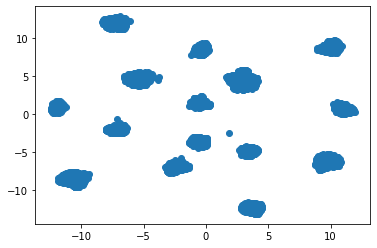

In [6]:
umap = UMAP(n_neighbors=25, min_dist=.3)
embed_2d = umap.fit_transform(m)
embed_2d = cupy.asnumpy( embed_2d )
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])

In [7]:
clst = DBSCAN(eps=1)
cluster_assignement = clst.fit_predict(embed_2d)

In [8]:
def hsv_to_rgb(h, s=.5, v=1.):
        if s == 0.0: v*=255; return (v, v, v)
        i = int(h*6.) # XXX assume int() truncates!
        f = (h*6.)-i; p,q,t = int(255*(v*(1.-s))), int(255*(v*(1.-s*f))), int(255*(v*(1.-s*(1.-f)))); v*=255; i%=6
        if i == 0: return (v, t, p)
        if i == 1: return (q, v, p)
        if i == 2: return (p, v, t)
        if i == 3: return (p, q, v)
        if i == 4: return (t, p, v)
        if i == 5: return (v, p, q)

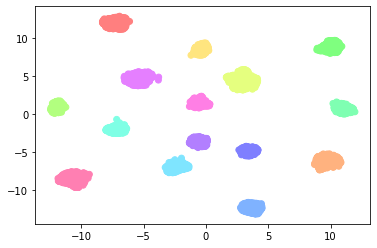

In [9]:
for x in range(15):
    embs = embed_2d[cluster_assignement == x]
    c = [x/255 for x in hsv_to_rgb(x / 15)]
    plt.scatter(embs[:, 0], embs[:, 1], c=[c] * len(embs))


In [10]:
cluster_map = dict(zip(df['id'].values_host, cluster_assignement))

In [11]:
data = pd.read_csv('train.csv')

In [12]:
print(data.loc[data.discourse_id==1623258656795.0, 'discourse_text'][8916])

This whole thing is point less how they have us in here for two days im missing my education. We could have finished this in one day and had the rest of the week to get back on the track of learning. I've missed both days of weight lifting, algebra, and my world history that i do not want to fail again! If their are any people actually gonna sit down and take the time to read this then

DO NOT DO THIS NEXT YEAR

.

They are giving us cold lunches. ham and cheese and an apple, I am 16

years old and my body needs proper food. I wouldnt be complaining if they served actual breakfast. but because of Michelle Obama and her healthy diet rule they surve us 1 poptart in the moring. How does the school board expect us to last from 7:05-12:15 on a pop tart? then expect us to get A's, we are more focused on lunch than anything else. I am about done so if you have the time to read this even though this does not count. Bring PROPER_NAME a big Mac from mc donalds, SCHOOL_NAME, (idk area code but it

In [13]:
data_before = pd.read_csv('train.csv')

In [14]:
print(data_before.loc[data_before.discourse_id==1623258656795.0, 'discourse_text'][8916])

This whole thing is point less how they have us in here for two days im missing my education. We could have finished this in one day and had the rest of the week to get back on the track of learning. I've missed both days of weight lifting, algebra, and my world history that i do not want to fail again! If their are any people actually gonna sit down and take the time to read this then

DO NOT DO THIS NEXT YEAR

.

They are giving us cold lunches. ham and cheese and an apple, I am 16

years old and my body needs proper food. I wouldnt be complaining if they served actual breakfast. but because of Michelle Obama and her healthy diet rule they surve us 1 poptart in the moring. How does the school board expect us to last from 7:05-12:15 on a pop tart? then expect us to get A's, we are more focused on lunch than anything else. I am about done so if you have the time to read this even though this does not count. Bring PROPER_NAME a big Mac from mc donalds, SCHOOL_NAME, (idk area code but it

In [15]:
data['cluster_id'] = data['id'].map(lambda x: cluster_map[x])

In [16]:
colors = {
            'Lead': '#8000ff',
            'Position': '#2b7ff6',
            'Evidence': '#2adddd',
            'Claim': '#80ffb4',
            'Concluding Statement': 'd4dd80',
            'Counterclaim': '#ff8042',
            'Rebuttal': '#ff0000'
         }
options = {"ents": list(colors.keys()), "colors": colors}

In [17]:
data

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,cluster_id
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,13
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,13
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,13
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,13
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,13
...,...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...,1
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...,1
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838,1
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...,1


In [18]:
c = Counter()
for z in data.discourse_text.values:
    c.update(z)

In [19]:
sorted(c.items(), key=lambda x: x[1])

[('ó', 1),
 ('^', 1),
 ('£', 1),
 ('Ó', 1),
 ('\x83', 1),
 ('©', 1),
 ('º', 1),
 ('Ë', 1),
 ('þ', 1),
 ('®', 1),
 ('å', 1),
 ('<', 1),
 ('>', 2),
 ('°', 2),
 ('\x91', 2),
 ('¬', 2),
 ('\x85', 3),
 ('@', 5),
 ('\x80', 5),
 ('â', 5),
 ('|', 6),
 ('{', 6),
 ('~', 6),
 ('}', 7),
 ('¢', 7),
 ('=', 19),
 ('\\', 20),
 ('*', 29),
 ('\x97', 63),
 ('Z', 71),
 ('X', 74),
 ('Q', 74),
 ('\x94', 81),
 ('\x93', 81),
 ('+', 85),
 ('\x92', 102),
 ('#', 111),
 ('\x82', 126),
 ('Ã', 130),
 ('Â', 137),
 ('`', 165),
 ('´', 231),
 ('¨', 251),
 ('&', 252),
 (']', 278),
 ('[', 289),
 ('$', 628),
 ('%', 1652),
 ('K', 1680),
 ('/', 2017),
 (':', 2104),
 ('J', 2211),
 ('4', 3095),
 ('8', 3206),
 ('6', 3288),
 (';', 3358),
 ('7', 3543),
 ('_', 3561),
 ('!', 3639),
 ('(', 4188),
 (')', 4224),
 ('5', 4796),
 ('9', 4833),
 ('3', 5210),
 ('U', 5660),
 ('R', 5843),
 ('Y', 8180),
 ('2', 8388),
 ('L', 8407),
 ('G', 9531),
 ('1', 9598),
 ('?', 11067),
 ('D', 11633),
 ('z', 11834),
 ('H', 11973),
 ('O', 12465),
 ('V', 133

In [20]:
print('\x82')




In [21]:
data.loc[data.discourse_id==1623258656795.0, 'id']

8916    F91D7BB4277C
Name: id, dtype: object

In [22]:
print(data.loc[data.discourse_id==1623258656795.0, 'discourse_text'][8916])

This whole thing is point less how they have us in here for two days im missing my education. We could have finished this in one day and had the rest of the week to get back on the track of learning. I've missed both days of weight lifting, algebra, and my world history that i do not want to fail again! If their are any people actually gonna sit down and take the time to read this then

DO NOT DO THIS NEXT YEAR

.

They are giving us cold lunches. ham and cheese and an apple, I am 16

years old and my body needs proper food. I wouldnt be complaining if they served actual breakfast. but because of Michelle Obama and her healthy diet rule they surve us 1 poptart in the moring. How does the school board expect us to last from 7:05-12:15 on a pop tart? then expect us to get A's, we are more focused on lunch than anything else. I am about done so if you have the time to read this even though this does not count. Bring PROPER_NAME a big Mac from mc donalds, SCHOOL_NAME, (idk area code but it

In [23]:
data.loc[data.discourse_id==1623258656795.0, 'discourse_text'] = data.loc[data.discourse_id==1623258656795.0, 
                                                                          'discourse_text'].map(lambda x: x.replace('florida', 'LOCATION_NAME')).values

## Visualize text data

In [24]:
def show_sample(ID):
    
    with open(f'train/{ID}.txt', encoding='utf-8') as f:
        org_text = f.read()

    dsc = data.loc[data.id == ID].sort_values('discourse_start')
    
    ents = []
    pointer = 0
    for _, row in dsc.iterrows():
        entity = row.discourse_text.strip()
        
        # find the beginning of the 
        starts_at = org_text[pointer:].index(entity) + pointer
        ents.append({'start': starts_at, 'end': starts_at + len(entity), 'label': row.discourse_type})
        pointer = starts_at + len(entity)

    spacy.displacy.render({'text': org_text, 'ents': ents, 'title': ID}, style="ent",
                          options=options, manual=True, jupyter=True)

In [25]:
ID = 'F91D7BB4277C'

# # this id works
# ID = ids[0]

In [26]:
show_sample(ID)

In [27]:
regexp = re.compile('(?s:.)*[a-zA-z0-9].*')

## chunk Statistics
> Get the statistic information of chunks that has no label
- chunk number per ID
- chunk length per ID
- chunk relative length normalized by `labeled chunk length` per ID

**Additionally save information related to topic**
- chunk number per topic
- chunk length per topic
- chunk relative length normalized by `labeled chunk length` per topic

In [28]:
data.cluster_id.unique()

array([13,  5, 12,  7, 14, -1,  3, 11,  8,  2,  1,  9,  0, 10,  6,  4],
      dtype=int32)

In [29]:
# chunks by ID
other_chunks_rel_map = {}
other_chunks_abs_map = {}
other_chunks_num_map = {}

# chunks by 15 topics
num_other_chunks = [[] for _ in range(15)]
mean_abs_size_other_chunks = [[] for _ in range(15)]
mean_rel_size_other_chunks = [[] for _ in range(15)]

for ID in tqdm(ids):
    # other chunks - group of words that is not entity
    # ents - entity
    # segment_sizes - length of each entity
    
    other_chunks = []
    with open(f'train/{ID}.txt', encoding='utf-8') as f:
        org_text = f.read()
    
    segment_sizes = []
    
    # process text per ID
    id_df = data.loc[data.id == ID].sort_values('discourse_start')
    
    ents = []
    pointer = 0
    
    for _, row in id_df.iterrows():
        entity = row.discourse_text.strip()
        segment_sizes.append(len(entity))
        offset = org_text[pointer:].index(entity)
        
        # when there is get information about the chunks without label
        if offset > 0:
            stripped_bit = org_text[pointer: pointer + offset].strip()
            
            # reg exr
            if len(stripped_bit) and regexp.match(stripped_bit) is not None:
                offset_text_size = len(stripped_bit)
                other_chunks.append(offset_text_size)

        starts_at = offset + pointer
        ents.append({'start': starts_at, 'end': starts_at + len(entity), 'label': row.discourse_type})
        pointer = starts_at + len(entity)
     
    # check there is no overlapped index sets
    index_sets = [set(range(ent['start'], ent['end'])) for ent in ents]
    if len(index_sets) > 2:
        for a in range(len(index_sets)):
            for b in range(a + 1, len(index_sets)):
                 assert not index_sets[a].intersection(index_sets[b])
                    
    mean_segment_size = np.mean(segment_sizes)
    
    # topic has 15 types!
    topic = id_df.iloc[0].cluster_id
    
    chunk_absolute_len = 0 if not len(other_chunks) else np.mean(other_chunks)
    chunk_relative_len = 0 if not len(other_chunks) else np.mean(other_chunks) / mean_segment_size
    chunk_n = len(other_chunks)
    
    # per topic
    mean_abs_size_other_chunks[topic].append(chunk_absolute_len)
    mean_rel_size_other_chunks[topic].append(chunk_relative_len)
    num_other_chunks[topic].append(len(other_chunks))
    
    # per ID
    other_chunks_abs_map[ID] = chunk_absolute_len
    other_chunks_rel_map[ID] = chunk_relative_len
    other_chunks_num_map[ID] = chunk_n

100% 15594/15594 [01:48<00:00, 143.55it/s]


In [30]:
all_ids = list(other_chunks_num_map.keys())

In [31]:
show_sample(all_ids[np.argmin([other_chunks_rel_map[x] for x in all_ids])])

In [32]:
show_sample(all_ids[np.argmax([other_chunks_rel_map[x] for x in all_ids])])

In [33]:
ents2idx = dict(zip(colors.keys(), range(len(colors))))
ents2idx

{'Lead': 0,
 'Position': 1,
 'Evidence': 2,
 'Claim': 3,
 'Concluding Statement': 4,
 'Counterclaim': 5,
 'Rebuttal': 6}

In [34]:
def count_entities(df):    
    ent_counts = np.zeros(7)
    for _, row in df.iterrows():
        ent_counts[ents2idx[row.discourse_type]] += 1

    return ent_counts

In [35]:
# count how many text's no label chunk has bigger relative size than 0.5 for each topic
[sum([rel_size > .5 for rel_size in mean_rel_size_other_chunks[topic]]) for topic in range(15)]

[19, 136, 74, 129, 76, 118, 44, 107, 83, 15, 20, 80, 46, 23, 119]

In [36]:
data.cluster_id.nunique()

16

## Split data
> `counts per discourse` and `UMAP clustering` is used to split data

```python
UMAP(n_neighbors=nn, n_components=1, random_state=seed)
```

- Seeds for umap clustering 
- Number of neighbors
- Use normalization(75% quantile among cluster discourse counts) for `counter per discourse` of not

In [37]:
nseeds = 5
nfolds = 5

all_splits = {}
for seed in range(nseeds):
    
    all_splits[seed] = {}
    for nn in tqdm((25, 50, 100, 150, 250)):
        
        all_splits[seed][nn] = {}
        for normed, key in zip((True, False), ('normed', 'not_normed')):
            
            fold_ids = [[] for _ in range(nfolds)]
            
            # split by each topic(cluster)!
            for cluster_id in range(15):
                
                cluster_df = data.loc[data.cluster_id == cluster_id]
                cluster_counts_df = cluster_df.groupby('id').apply(count_entities)
                text_ids = cluster_counts_df.index 
                
                # text that relative size of no label chunk is bigger than 50%
                much_free_text_ids = set(text_id for text_id in text_ids if other_chunks_rel_map[text_id] > .5)
                sorted_much_free_text_ids = sorted(much_free_text_ids, key=lambda x: other_chunks_rel_map[x])
                cluster_ent_embs = np.vstack(cluster_counts_df.values)
                
                # use 75 quantile of each discourse element counts among texts for normalization
                eps = 1
                if normed:
                    cluster_ent_embs /= (np.quantile(cluster_ent_embs, .75, axis=0,) + eps)
                
                umap = UMAP(n_neighbors=nn, n_components=1, random_state=seed)
                embs_1d = umap.fit_transform(cupy.array(cluster_ent_embs))    
                sorted_index = np.argsort(embs_1d.get().ravel())
                
                for fold in range(nfolds):
                    # includes text that relative size of no label chunk is smaller than 50%
                    fold_ids[fold].extend(text_id for text_id in text_ids[sorted_index[fold::5]] if text_id not in much_free_text_ids)
                    
                    # includes text that relative size of no label chunk is bigger than 50%
                    fold_ids[fold].extend(sorted_much_free_text_ids[fold::5])
            
            # check fold doens't include the same texts
            for fold_cur in range(nfolds):
                for fold_next in range(a + 1, nfolds):
                    assert not set(fold_ids[fold_cur]).intersection(set(fold_ids[fold_next]))

            all_splits[seed][nn][key] = fold_ids

100% 5/5 [01:14<00:00, 14.89s/it]
100% 5/5 [01:13<00:00, 14.61s/it]
100% 5/5 [01:13<00:00, 14.60s/it]
100% 5/5 [01:14<00:00, 14.84s/it]
100% 5/5 [01:15<00:00, 15.01s/it]


In [188]:
with open('data_splits.pickle', 'wb') as f:
    import dill as pickle
    pickle.dump(all_splits, f)

In [190]:
[len(x) for x in all_splits[0][250]['normed']]

[3140, 3121, 3139, 3096, 3098]